# FRG Inclusion into the BMM procedure

## Alexandra Semposki

### Date begun: 22 October 2023

In [137]:
# import packages
%load_ext autoreload
%autoreload 2

import gsum as gm
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, AutoMinorLocator, MaxNLocator
import scipy.stats as stats
import os
import sys
from scipy.interpolate import interp1d
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, Matern, WhiteKernel
from sklearn.gaussian_process import GaussianProcessRegressor
import scipy.integrate as sc
import scipy.optimize as opt
import scipy.interpolate as inter
from collections import defaultdict
import pandas as pd
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [138]:
# import Taweret
import sys
sys.path.append('../../Taweret')

# import from Taweret all modules
from Taweret.core.base_model import BaseModel
from Taweret.mix.gaussian import Multivariate

In [139]:
# import plotting script from J. Melendez
from scripts import *
setup_rc_params()

In [140]:
# import the classes for chiral EFT and pQCD
from chiral_model import Chiral_model

from pqcd_reworked import PQCD
from gorda_model import Gorda
from truncation_error import Truncation

## Density definition

In [151]:
density = np.linspace(0.05, 16.0, 300)  # total density space
n0 = 0.16

## FRG data import and plot

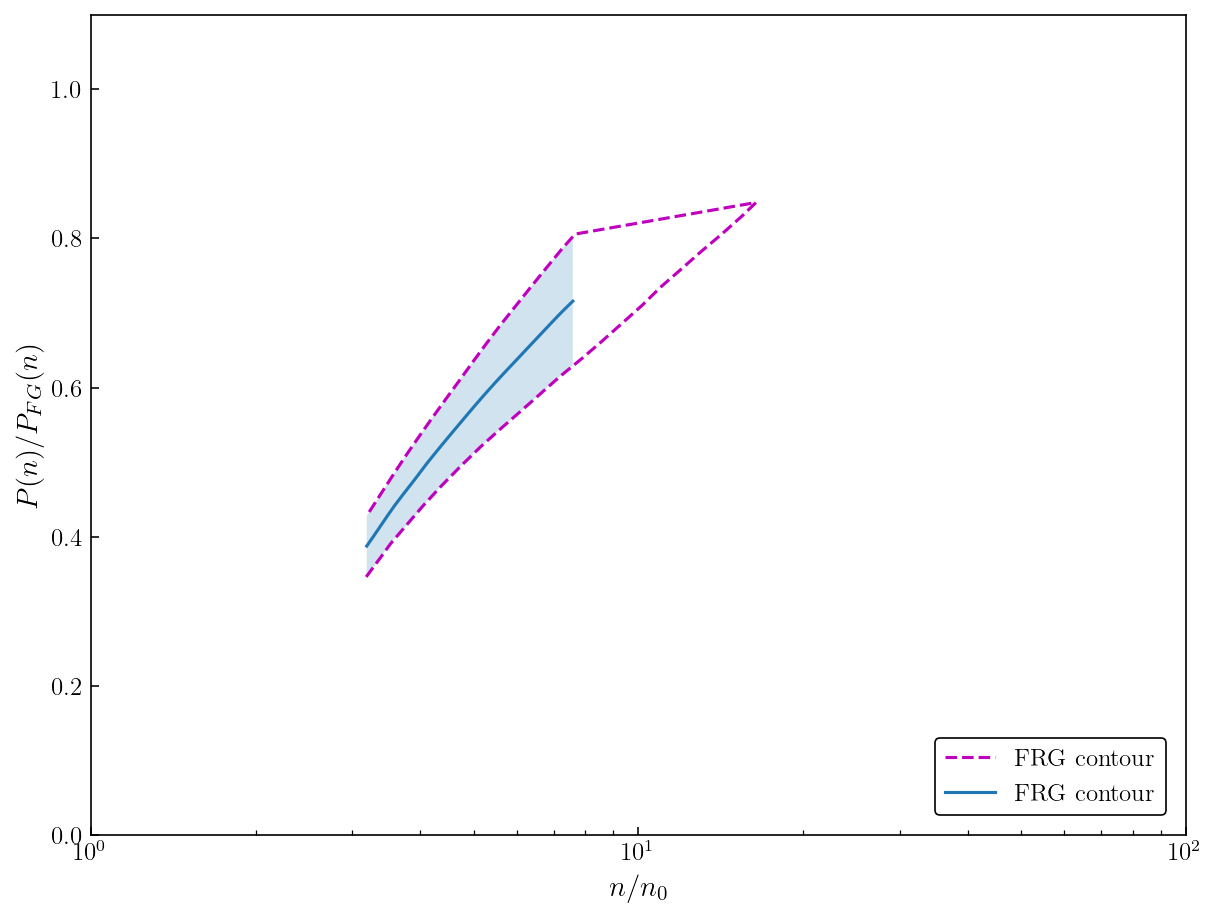

In [152]:
# read in FRG contour
df_frg = pd.read_csv('frg_data_pressure.csv')
df_frg_cd = pd.read_csv('frg_lower_upper.csv', names=["scaled_density", "lower", "upper", "mean", "std"])
#display(df_frg_cd)
#display(df_frg)

# plot FRG to start
fig = plt.figure(figsize=(8,6), dpi=150)
ax = plt.axes()
ax.set_xlim(1.0, max(density/n0))
ax.set_ylim(0.0,1.1)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=10)
ax.set_xlabel(r'$n/n_{0}$', fontsize=14)
ax.set_ylabel(r'$P(n)/P_{FG}(n)$', fontsize=14)
plt.plot(df_frg['n/n0'], df_frg['P/P_free'], color='m', linestyle='dashed', label='FRG contour')
plt.plot(df_frg_cd['scaled_density'], df_frg_cd['mean'], label=r'FRG contour')
plt.fill_between(df_frg_cd['scaled_density'], df_frg_cd['mean']-df_frg_cd['std'], \
                 df_frg_cd['mean']+df_frg_cd['std'], alpha=0.2)
plt.xscale('log')
plt.legend(loc='lower right', fontsize=12)
plt.show()

## FRG class for Taweret

In [167]:
# design the GP class we'll need for the interpolant
class FRG_model(BaseModel):
    
    def __init__(self, density, df):
        
        # import the testing input space
        self.density = density
        
        # import the FRG data set
        self.df = df
        
        # extract the values here
        self.dens_scaled = self.df['scaled_density']
        self.dens = self.dens_scaled*0.16
        self.mean = self.df['mean'] 
        self.std = self.df['std']
        
        # plot this here real quick
        plt.plot(self.dens, self.mean)
        plt.fill_between(self.dens, self.mean-self.std, self.mean+self.std, alpha=0.2)
      
        return None
    
    # design mean and std dev here (density input from testing set)
    def evaluate(self, density):
        
        # interpolate data set and extrapolate
        frg_interp = interp1d(self.dens, self.mean, fill_value='extrapolate')
        std_interp = interp1d(self.dens, self.std, fill_value='extrapolate')
        
        # call frg_interp at other values
        mean = frg_interp(density)
        std = std_interp(density)
        
        # find the edges of the array where real values are
        low_ind = np.where([density >= min(self.dens)])[1][0]
        hi_ind = np.where([density <= max(self.dens)])[1][-1]
        
        # fill everything below and above with zeros
        for i in range(len(density)):
            if i < low_ind:
                mean[i] = -10.0
                std[i] = 1e10
            elif i > hi_ind:
                mean[i] = -10.0
                std[i] = 1e10
                
        # make indices accessible for GP use
        self.low_ind = low_ind
        self.hi_ind = hi_ind
        
        return mean, std
    
    # define prior function
    def set_prior(self):       
        return None 
    
    # define likelihood
    def log_likelihood_elementwise(self):       
        return None

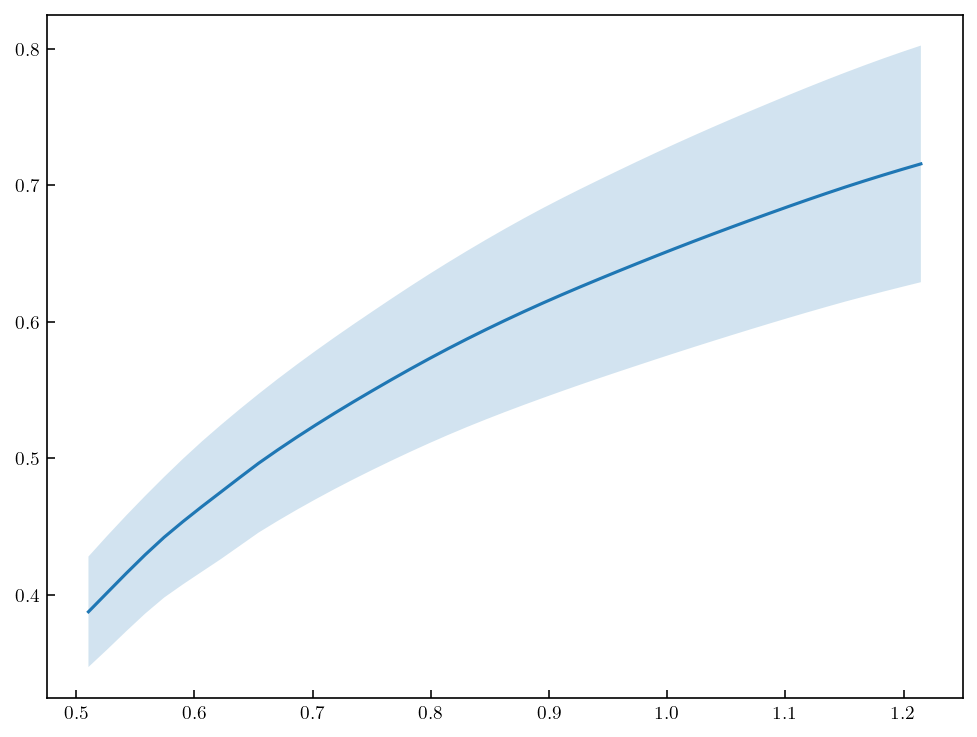

In [168]:
frg = FRG_model(density, df_frg_cd)

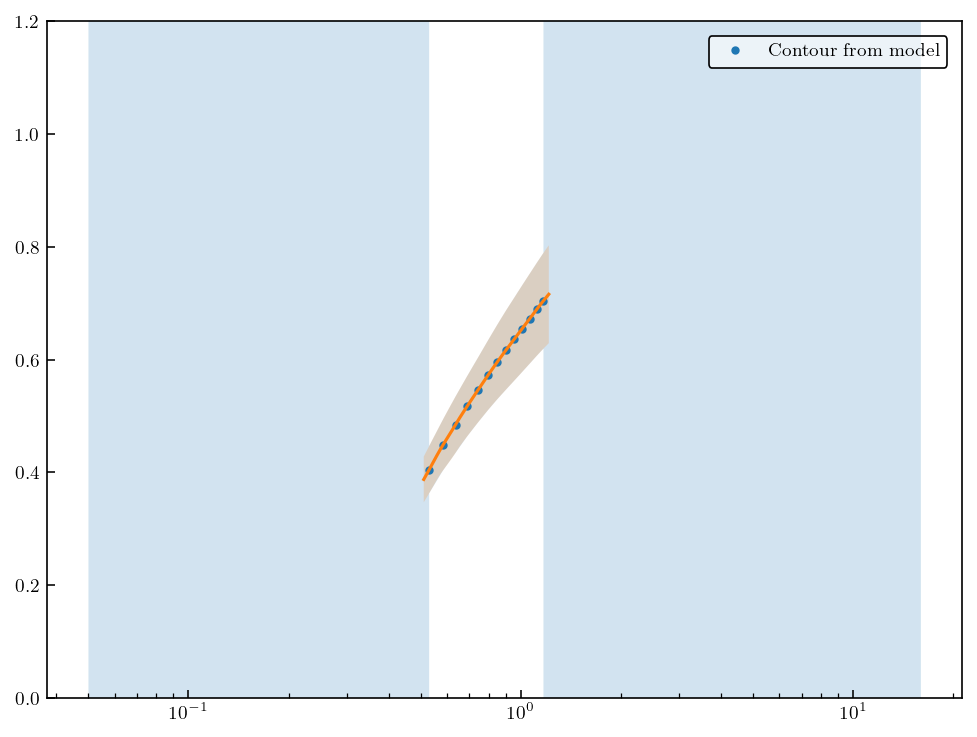

In [169]:
frg_mean, frg_std = frg.evaluate(density)
df_frg_cd = pd.read_csv('frg_lower_upper.csv', names=["scaled_density", "lower", "upper", "mean", "std"])
plt.ylim(0.0, 1.2)
plt.plot(density, frg_mean, '.', label=r'Contour from model')
plt.fill_between(density, frg_mean-frg_std, frg_mean+frg_std, alpha=0.2)
plt.plot(df_frg_cd['scaled_density']*0.16, df_frg_cd['mean'])
plt.fill_between(df_frg_cd['scaled_density']*0.16, df_frg_cd['mean']-df_frg_cd['std'], \
                 df_frg_cd['mean']+df_frg_cd['std'], alpha=0.2)
plt.xscale('log')
plt.legend()

## $\chi$EFT EOS

In [156]:
#instantiate pqcd EOS for SNM
pqcdk = PQCD(X=2,Nf=2)    # fix this whole mess here (inherit into Gorda...)

# take the density and invert to obtain the corresponding mu
mu_FG, mu_n = pqcdk.n_convert_mu(density)

# evaluate model (N2LO only)
pqcd = Gorda(mu=mu_n, X=2, Nf=2, mu_FG=mu_FG)
mean_pqcd, std_dev_pqcd = pqcd.evaluate(N2LO=True, scaled=True)

# instantiate the chiral EOS
chiral = Chiral_model(density=density, Lambda=500, high_density=True)

# evaluate model (N3LO only)
mean_chiral, std_dev_chiral = chiral.evaluate(N3LO=True, scaled=True)

C:\Users\Alexandra\anaconda3\envs\BUQEYE\lib\site-packages\scipy\optimize\_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\Alexandra\anaconda3\envs\BUQEYE\lib\site-packages\scipy\optimize\_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


RBF(length_scale=8.33) + WhiteKernel(noise_level=1e-05)
0.7997504473785797


C:\Users\Alexandra\Desktop\EOSBMM\buqeyenm\pqcd_reworked.py:102: RuntimeWarning: invalid value encountered in log
  alpha_s = ((4.0*np.pi)/(self.beta0*ell)) * (1.0 - (2.0*beta1*np.log(ell))/(ell*self.beta0**2.0))
C:\Users\Alexandra\anaconda3\envs\BUQEYE\lib\site-packages\gsum\models.py:1340: RuntimeWarning: invalid value encountered in multiply
  return self.ref(X) * ratio_sum * coeff_mean
C:\Users\Alexandra\anaconda3\envs\BUQEYE\lib\site-packages\numpy\lib\nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
C:\Users\Alexandra\anaconda3\envs\BUQEYE\lib\site-packages\numdifftools\limits.py:150: UserWarning: All-NaN slice encountered
  warnings.warn(str(msg))


Setting up neutron matter...
For EFT order 0, the best polynomial has max nu = 8
For EFT order 2, the best polynomial has max nu = 8
For EFT order 3, the best polynomial has max nu = 8
For EFT order 4, the best polynomial has max nu = 8
Setting up nuclear matter...
For EFT order 0, the best polynomial has max nu = 8
For EFT order 2, the best polynomial has max nu = 6
For EFT order 3, the best polynomial has max nu = 8
For EFT order 4, the best polynomial has max nu = 7
Setting up symmetry energy...
0.973 0.484 0.8119689713375328
For EFT order 0, the best polynomial has max nu = 7


C:\Users\Alexandra\Desktop\EOSBMM\buqeyenm\../buqeyenm/nuclear-matter-convergence\nuclear_matter\derivatives.py:323: RuntimeWarning: invalid value encountered in sqrt
  d[i] = np.sqrt(np.diag(cov_ij))


For EFT order 2, the best polynomial has max nu = 7
For EFT order 3, the best polynomial has max nu = 7
For EFT order 4, the best polynomial has max nu = 7
Setup time: 68.75947189331055


In [170]:
# set up new chiral class for running with pre-selected data
class Chiralmodel(BaseModel):
    
    def __init__(self, density, mean, std):
        
        self.density = density
        self.mean = mean
        self.std = std
        
        return None
    
    def evaluate(self, density):
        
        return self.mean, self.std
    
    def log_likelihood_elementwise(self):
        return None
    def set_prior(self):
        return None
    
class PQCDmodel(BaseModel):
    
    def __init__(self, density, mean, std):
        
        self.density = density
        self.mean = mean
        self.std = std
        
        return None
    
    def evaluate(self, density):
        return self.mean, self.std
    
    def log_likelihood_elementwise(self):
        return None
    def set_prior(self):
        return None
    
# instantiate both of these models for mixing
chiral_mixing = Chiralmodel(density, mean_chiral, std_dev_chiral)
pqcd_mixing = PQCDmodel(density, mean_pqcd, std_dev_pqcd)

In [171]:
# mix our models by setting them up and sending to Taweret
models = {
    "chiral" : chiral_mixing,
    "frg" : frg,
    "pqcd" : pqcd_mixing
}

print(pqcd.trunc.kernel)

# instantiate Multivariate class (using testing density array)
mixed_model = Multivariate(density, models, n_models=len(models))

# call predict
_, mixed_mean, mixed_intervals, mixed_std = mixed_model.predict(ci=68, correlated=False)

RBF(length_scale=8.33) + WhiteKernel(noise_level=1e-05)


In [193]:
import matplotlib.patches as mpatches
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from matplotlib import legend_handler
from matplotlib.legend_handler import HandlerLine2D

mpl.rcParams['legend.title_fontsize'] = 12
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['legend.edgecolor'] = 'inherit'  # inherits from axes.edgecolor, to match
mpl.rcParams['legend.facecolor'] = (1, 1, 1, 0.6)  # Set facecolor with its own alpha, so edgecolor is unaffected
mpl.rcParams['legend.fancybox'] = True
mpl.rcParams['legend.borderaxespad'] = 0.8
mpl.rcParams['legend.framealpha'] = None  # Do not set overall alpha (affects edgecolor). Handled by facecolor above
mpl.rcParams['patch.linewidth'] = 0.8  # This is for legend edgewidth, since it does not have its own option

mpl.rcParams['hatch.linewidth'] = 0.5

class OrderBandsHandler(legend_handler.HandlerPolyCollection):

    def create_artists(self, legend, orig_handle, xdescent, ydescent, width, height, fontsize, trans):
        light_rect = orig_handle[0]
        dark_rect = orig_handle[1]
        dark_line = orig_handle[2]
        dark_color = dark_line.get_color()
        color = dark_rect.get_facecolor()[0]
        light_color = light_rect.get_facecolor()[0]
        lw = 0.8

        outer_rect = mpatches.Rectangle(
            [0, 0], 1, 1, facecolor='none', edgecolor=dark_color,
            lw=lw
        )
        dark_rect = mpatches.Rectangle(
            [0, 0], 1, 1, facecolor=color, edgecolor='none',
            lw=0
        )
        light_rect = mpatches.Rectangle(
            [0, 0], 1, 1, facecolor=light_color, edgecolor='none',
            lw=0
        )

        patches = []

        factor = 2
        dark_height = 0.4 * height
        patches += legend_handler.HandlerPatch().create_artists(
            legend, light_rect, xdescent, ydescent, width, height, fontsize, trans)
        patches += legend_handler.HandlerPatch().create_artists(
            legend, dark_rect, xdescent, ydescent - height / 2 + dark_height/2, width, dark_height, fontsize, trans)
        outer_patches = legend_handler.HandlerPatch().create_artists(
            legend, outer_rect, xdescent, ydescent, width, height, fontsize, trans)
        outer_patches[0].set_linewidth(lw / 2)
        patches += outer_patches
        
        return patches


def compute_filled_handles(colors, light_colors, dark_colors):
    handles = []
    for color, light_color, dark_color in zip(colors, light_colors, dark_colors):
        fill_light = plt.fill_between([], [], [], alpha=1, color=light_color)
        fill_normal = plt.fill_between([], [], [], alpha=1, color=color)
        line_dark = plt.plot([], [], color=dark_color, dash_capstyle='butt', solid_capstyle='butt')[0]

        handles.append((fill_light, fill_normal, line_dark))
    return handles


def add_top_order_legend(fig, ax_left, ax_right, orders, colors, light_colors, dark_colors):
    fig.canvas.draw()  # Must draw to get positions right before getting locations
    # Get the corner of the upper right plot in display coordinates
    upper_right_display = ax_right.transAxes.transform((1, 1))
    # Now put it in axes[0,0] coords
    upper_right_axes00 = ax_left.transAxes.inverted().transform(upper_right_display)
    handlers_ords = compute_filled_handles(colors, light_colors, dark_colors)
    # Must use axes[0,0] legend for constrained layout to work with it
    return ax_left.legend(
        handlers_ords, orders, ncol=4,
        loc='lower left', bbox_to_anchor=(0, 1.02, upper_right_axes00[0], 1.),
        mode='expand',
        columnspacing=0,
        handletextpad=0.5,
        fancybox=False, borderaxespad=0,
        handler_map={tuple: OrderBandsHandler()}
    )

def add_legend(fig, orders, colors, light_colors, dark_colors):
    handlers_ords = compute_filled_handles(colors, light_colors, dark_colors)
    return ax.legend(
    handlers_ords, orders, ncol=1, loc='lower right', fancybox=False, borderaxespad=0,
    handler_map={tuple: OrderBandsHandler()})

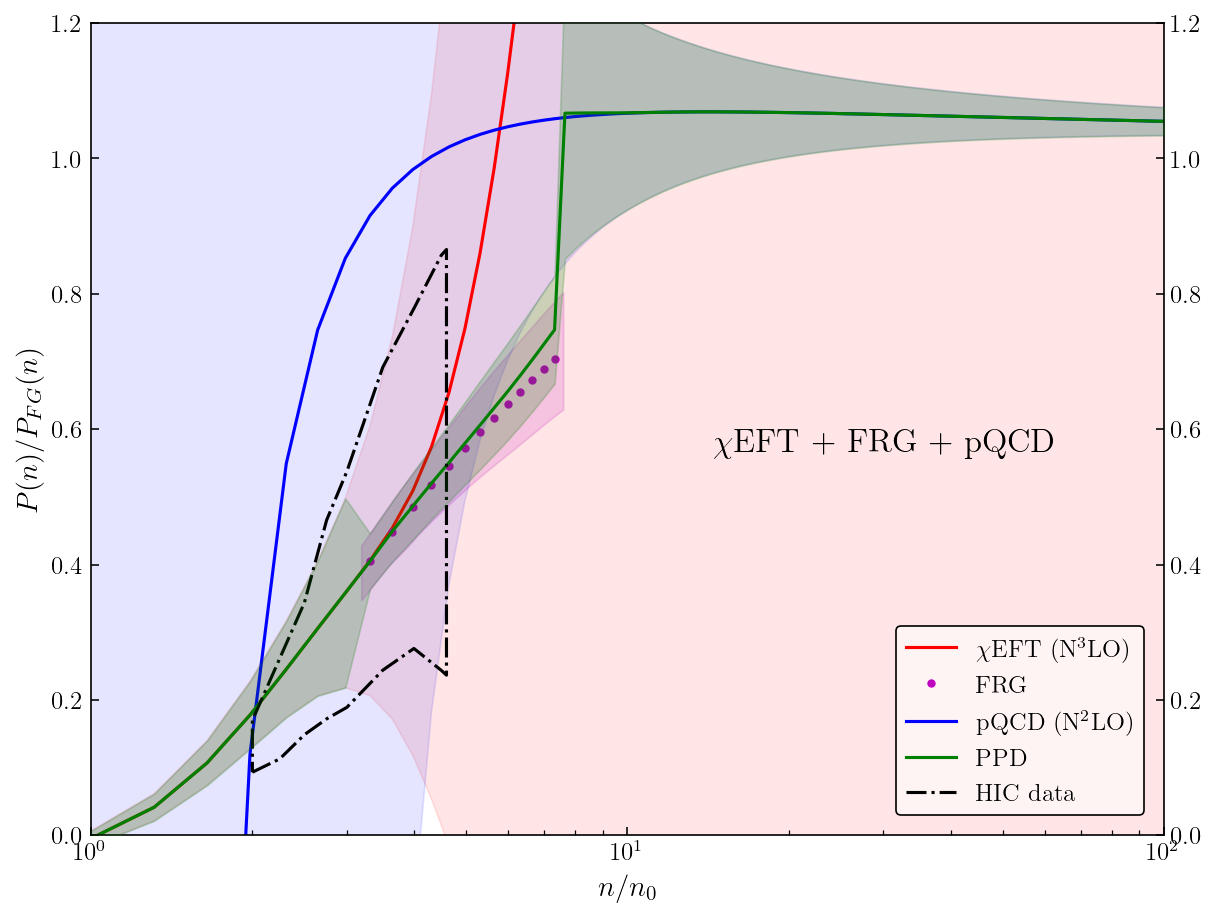

In [212]:
# plot BMM result
fig = plt.figure(figsize=(8,6), dpi=150)
ax = plt.axes()
ax.set_xlim(1., max(density/n0))
ax.set_ylim(0.0,1.2)
ax.tick_params(axis='both', which='major', labelsize=12, labelright=True, right=True)
ax.tick_params(axis='both', which='minor', labelsize=10, labelright=True)
ax.text(0.9,0.5, r'$\chi$EFT + FRG + pQCD', ha='right', va='top',
        transform=ax.transAxes, fontsize=16)
ax.set_xlabel(r'$n/n_{0}$', fontsize=14)
ax.set_ylabel(r'$P(n)/P_{FG}(n)$', fontsize=14)

colors = ['r', 'm', 'b', 'g']
labels = [r'$\chi$EFT (N$^{3}$LO)', r'FRG', r'pQCD (N$^{2}$LO)', 'Mixed Model']

# model means
ax.plot(density/n0, mean_chiral, color=colors[0], label=labels[0])
ax.plot(density/n0, frg_mean, marker='.', linestyle=' ', color=colors[1], label=labels[1])
ax.plot(density/n0, mean_pqcd, color=colors[2], label=labels[2])

# PPD mean (testing data array)
ax.plot(density/n0, mixed_mean, color='g', label='PPD')

# model uncertainties
ax.fill_between(density/n0, mean_chiral - 1.0*std_dev_chiral, mean_chiral + 1.0*std_dev_chiral, \
                color=colors[0], alpha=0.1)
ax.fill_between(df_frg_cd['scaled_density'], df_frg_cd['mean']-df_frg_cd['std'], df_frg_cd['mean']+df_frg_cd['std'], color=colors[1], alpha=0.15)
ax.fill_between(density/n0, mean_pqcd - 1.0*std_dev_pqcd, mean_pqcd + 1.0*std_dev_pqcd, \
                color=colors[2], alpha=0.1)

# HIC contour
df = pd.read_csv('contour_scaled.csv')
ax.plot(df['Density/n0'], df['p_pfg'], color='k', linestyle='dashdot', label='HIC data')


# PPD band (testing data array)
ax.fill_between(density/n0, mixed_mean-1.0*mixed_std, mixed_mean+1.0*mixed_std,
                        zorder=5, facecolor='g', edgecolor='g', alpha=0.2)
# legend
ax.set_xscale('log')
# color_wheel = ["r", "m", "b", "g"]
# texts = [r"$\chi$EFT", r"FRG", r"pQCD", r"Mixed model PPD"]
# patches = [mpatches.Patch(color=color_wheel[i], label="{:s}".format(texts[i]) ) for i in range(len(texts))]
light_colors = [lighten_color(color) for color in colors]
dark_colors = [lighten_color(color, 1.5) for color in colors]
ax.legend(loc='lower right', fontsize=12)
plt.show()

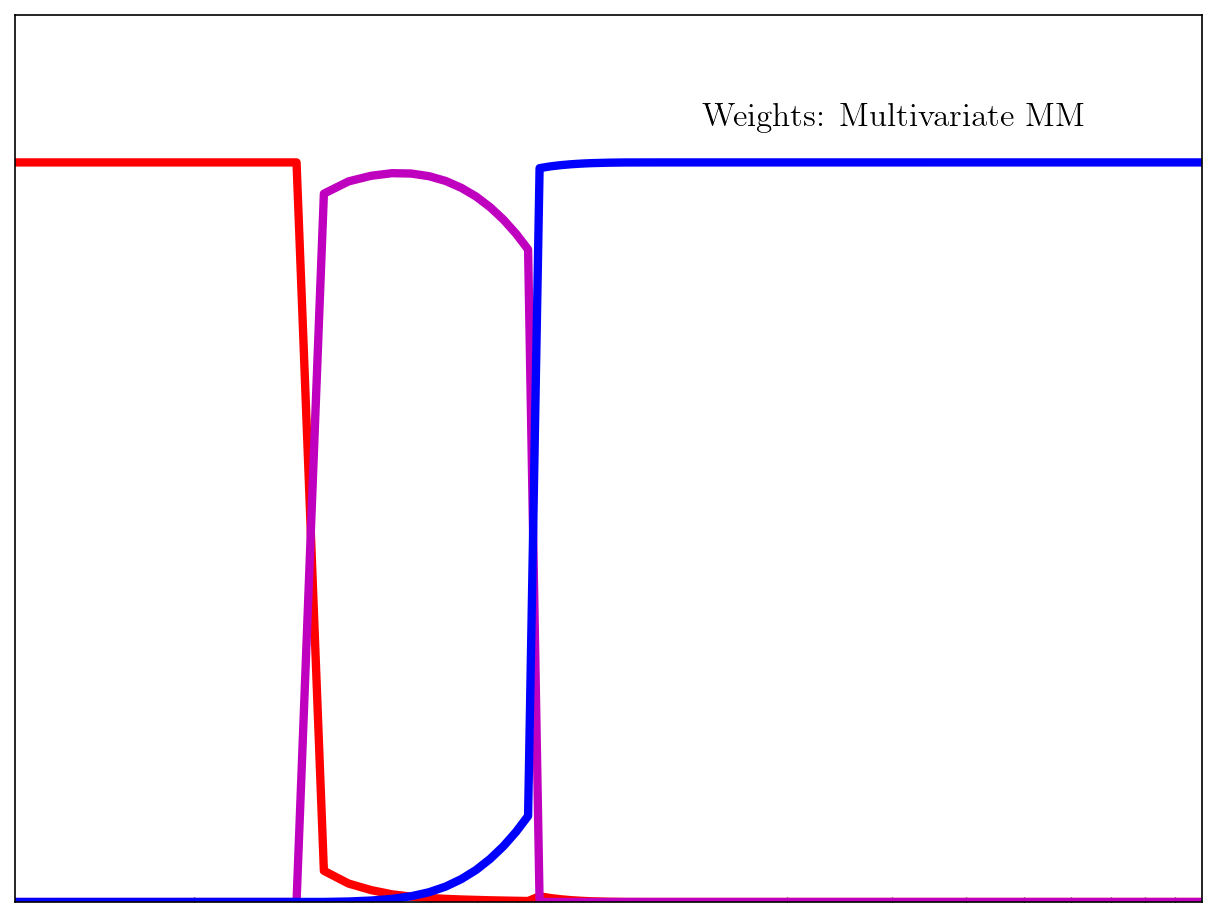

In [211]:
# plot the weights to see what's up
mixed_weights = mixed_model.evaluate_weights()

labels_weights = [r'$1/\sigma_{\chi \mathrm{EFT}}$', r'$1/\sigma_{\mathrm{FRG}}$', r'$1/\sigma_{\mathrm{pQCD}}$']

# plot the weights
fig = plt.figure(figsize=(8,6), dpi=150)
ax = plt.axes()
# ax.tick_params(axis='both', which='major', labelsize=12, labelright=True, right=True)
# ax.tick_params(axis='both', which='minor', labelsize=10, labelright=True)
ax.tick_params(left = False, right = False , labelleft = False , 
                labelbottom = False, bottom = False) 
ax.set_xlim(1.0,max(density)/n0)
ax.set_ylim(0.0,1.2)
ax.text(0.9,0.9, 'Weights: Multivariate MM', ha='right', va='top',
        transform=ax.transAxes, fontsize=16)
# ax.set_xlabel(r'$n/n_{0}$')
# ax.set_ylabel('Weights')

# model weights
for i in range(len(mixed_weights)):
    ax.plot(density/n0, mixed_weights[i], color=colors[i], label=labels_weights[i], linewidth=4)

# legend
ax.set_xscale('log')
plt.show()